In [1]:
%load_ext autoreload
%autoreload 2
# classifiers:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from lib.utils import ModelTester
from lib.utils.model_tester import generic_handler
from lib.utils import create_heatmap
from lib.db import connect
from lib.data.loader import LoanPerformanceDataset
from lib.enums import PRE_PROCESSING_ENCODERS_PICKLE_PATH, LIVE_PRE_PROCESSING_ENCODERS_PICKLE_PATH

In [2]:
LOCAL = True
USE_LIVE_PRE_PROCESSORS = not LOCAL
CHUNK_SIZE = 50000

dataset = LoanPerformanceDataset(
    chunk=CHUNK_SIZE,  # size of the query (use a large number here)
    conn=connect(local=LOCAL).connect(),  # connect to local or remote database (docker, google cloud)
    ignore_headers=['loan_id'],
    target_column='sdq',
    pre_process_pickle_path=LIVE_PRE_PROCESSING_ENCODERS_PICKLE_PATH if USE_LIVE_PRE_PROCESSORS else PRE_PROCESSING_ENCODERS_PICKLE_PATH,
    stage='train',
    to_tensor=False
)

X, y = dataset[0]

Connecting: {'host': 'localhost'} {}
Attempting load of: pickles/pre_processing_encoders.pkl
Loading pre-processors from pickles/pre_processing_encoders.pkl, adding 5 encoders


In [3]:
classifiers = [DecisionTreeClassifier, RandomForestClassifier]
classifier_args = {
    '0': dict(random_state=0),
    '1': dict(random_state=0, n_estimators=30, n_jobs=4),
}

In [4]:
tester = ModelTester(
    classifiers,
    X=X,
    y=y,
    clf_args=classifier_args,
    handlers={
        'DecisionTreeClassifier': generic_handler,
        'RandomForestClassifier': generic_handler
    }
)

In [6]:
results = list(tester.run_tests())

Running: DecisionTreeClassifier on 1026 features
Running: RandomForestClassifier on 1026 features


DecisionTreeClassifier - 0.77, RandomForestClassifier - 0.84


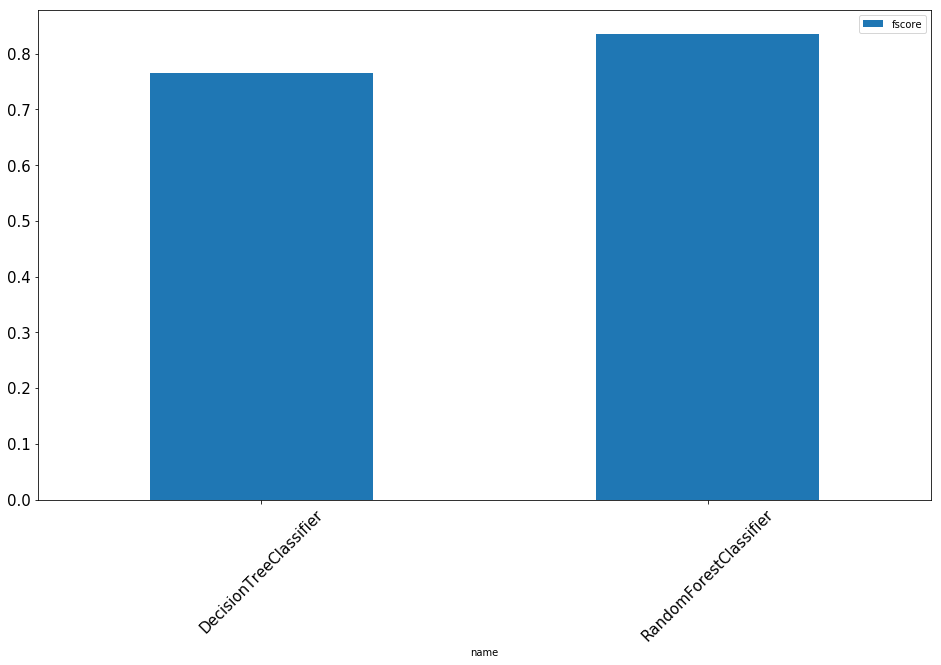

In [7]:
tester.plot_fscores()

Choosing top importances DecisionTreeClassifier


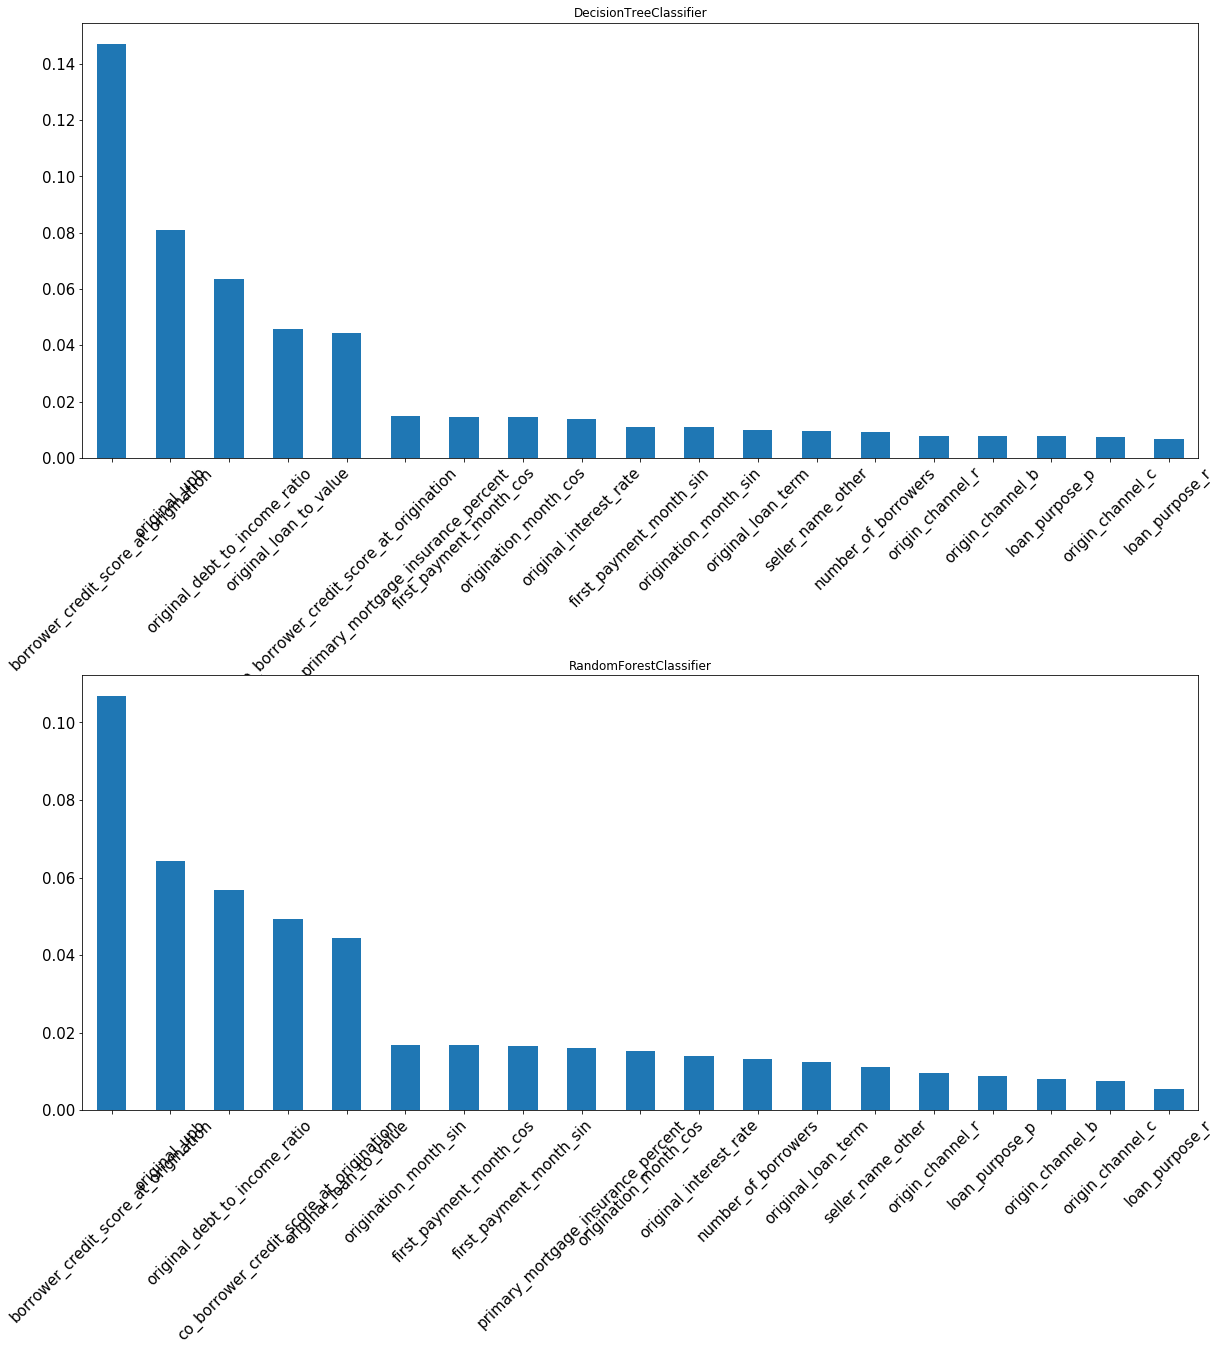

In [9]:
top = tester.plot_importances(top=True, std_dev_mult=1)
top_features = X[list(top.keys())[:8]]

In [14]:
print(top_features.sample(3))
print(top_features.columns) 
# ['borrower_credit_score_at_origination', 'original_upb',
#        'original_debt_to_income_ratio', 'original_loan_to_value',
#        'co_borrower_credit_score_at_origination',
#        'primary_mortgage_insurance_percent', 'first_payment_month_cos',
#        'origination_month_cos']

       borrower_credit_score_at_origination  original_upb  \
18033                              0.462146     -1.513060   
19045                              1.176759     -0.811515   
38528                             -0.820493      0.065416   

       original_debt_to_income_ratio  original_loan_to_value  \
18033                       0.408422               -3.170544   
19045                      -0.842253               -0.059422   
38528                      -2.092929                0.239724   

       co_borrower_credit_score_at_origination  \
18033                                 0.000000   
19045                                 0.381092   
38528                                 0.000000   

       primary_mortgage_insurance_percent  first_payment_month_cos  \
18033                                 0.0                -1.454617   
19045                                 0.0                -0.213981   
38528                                 0.0                -1.454617   

       originati

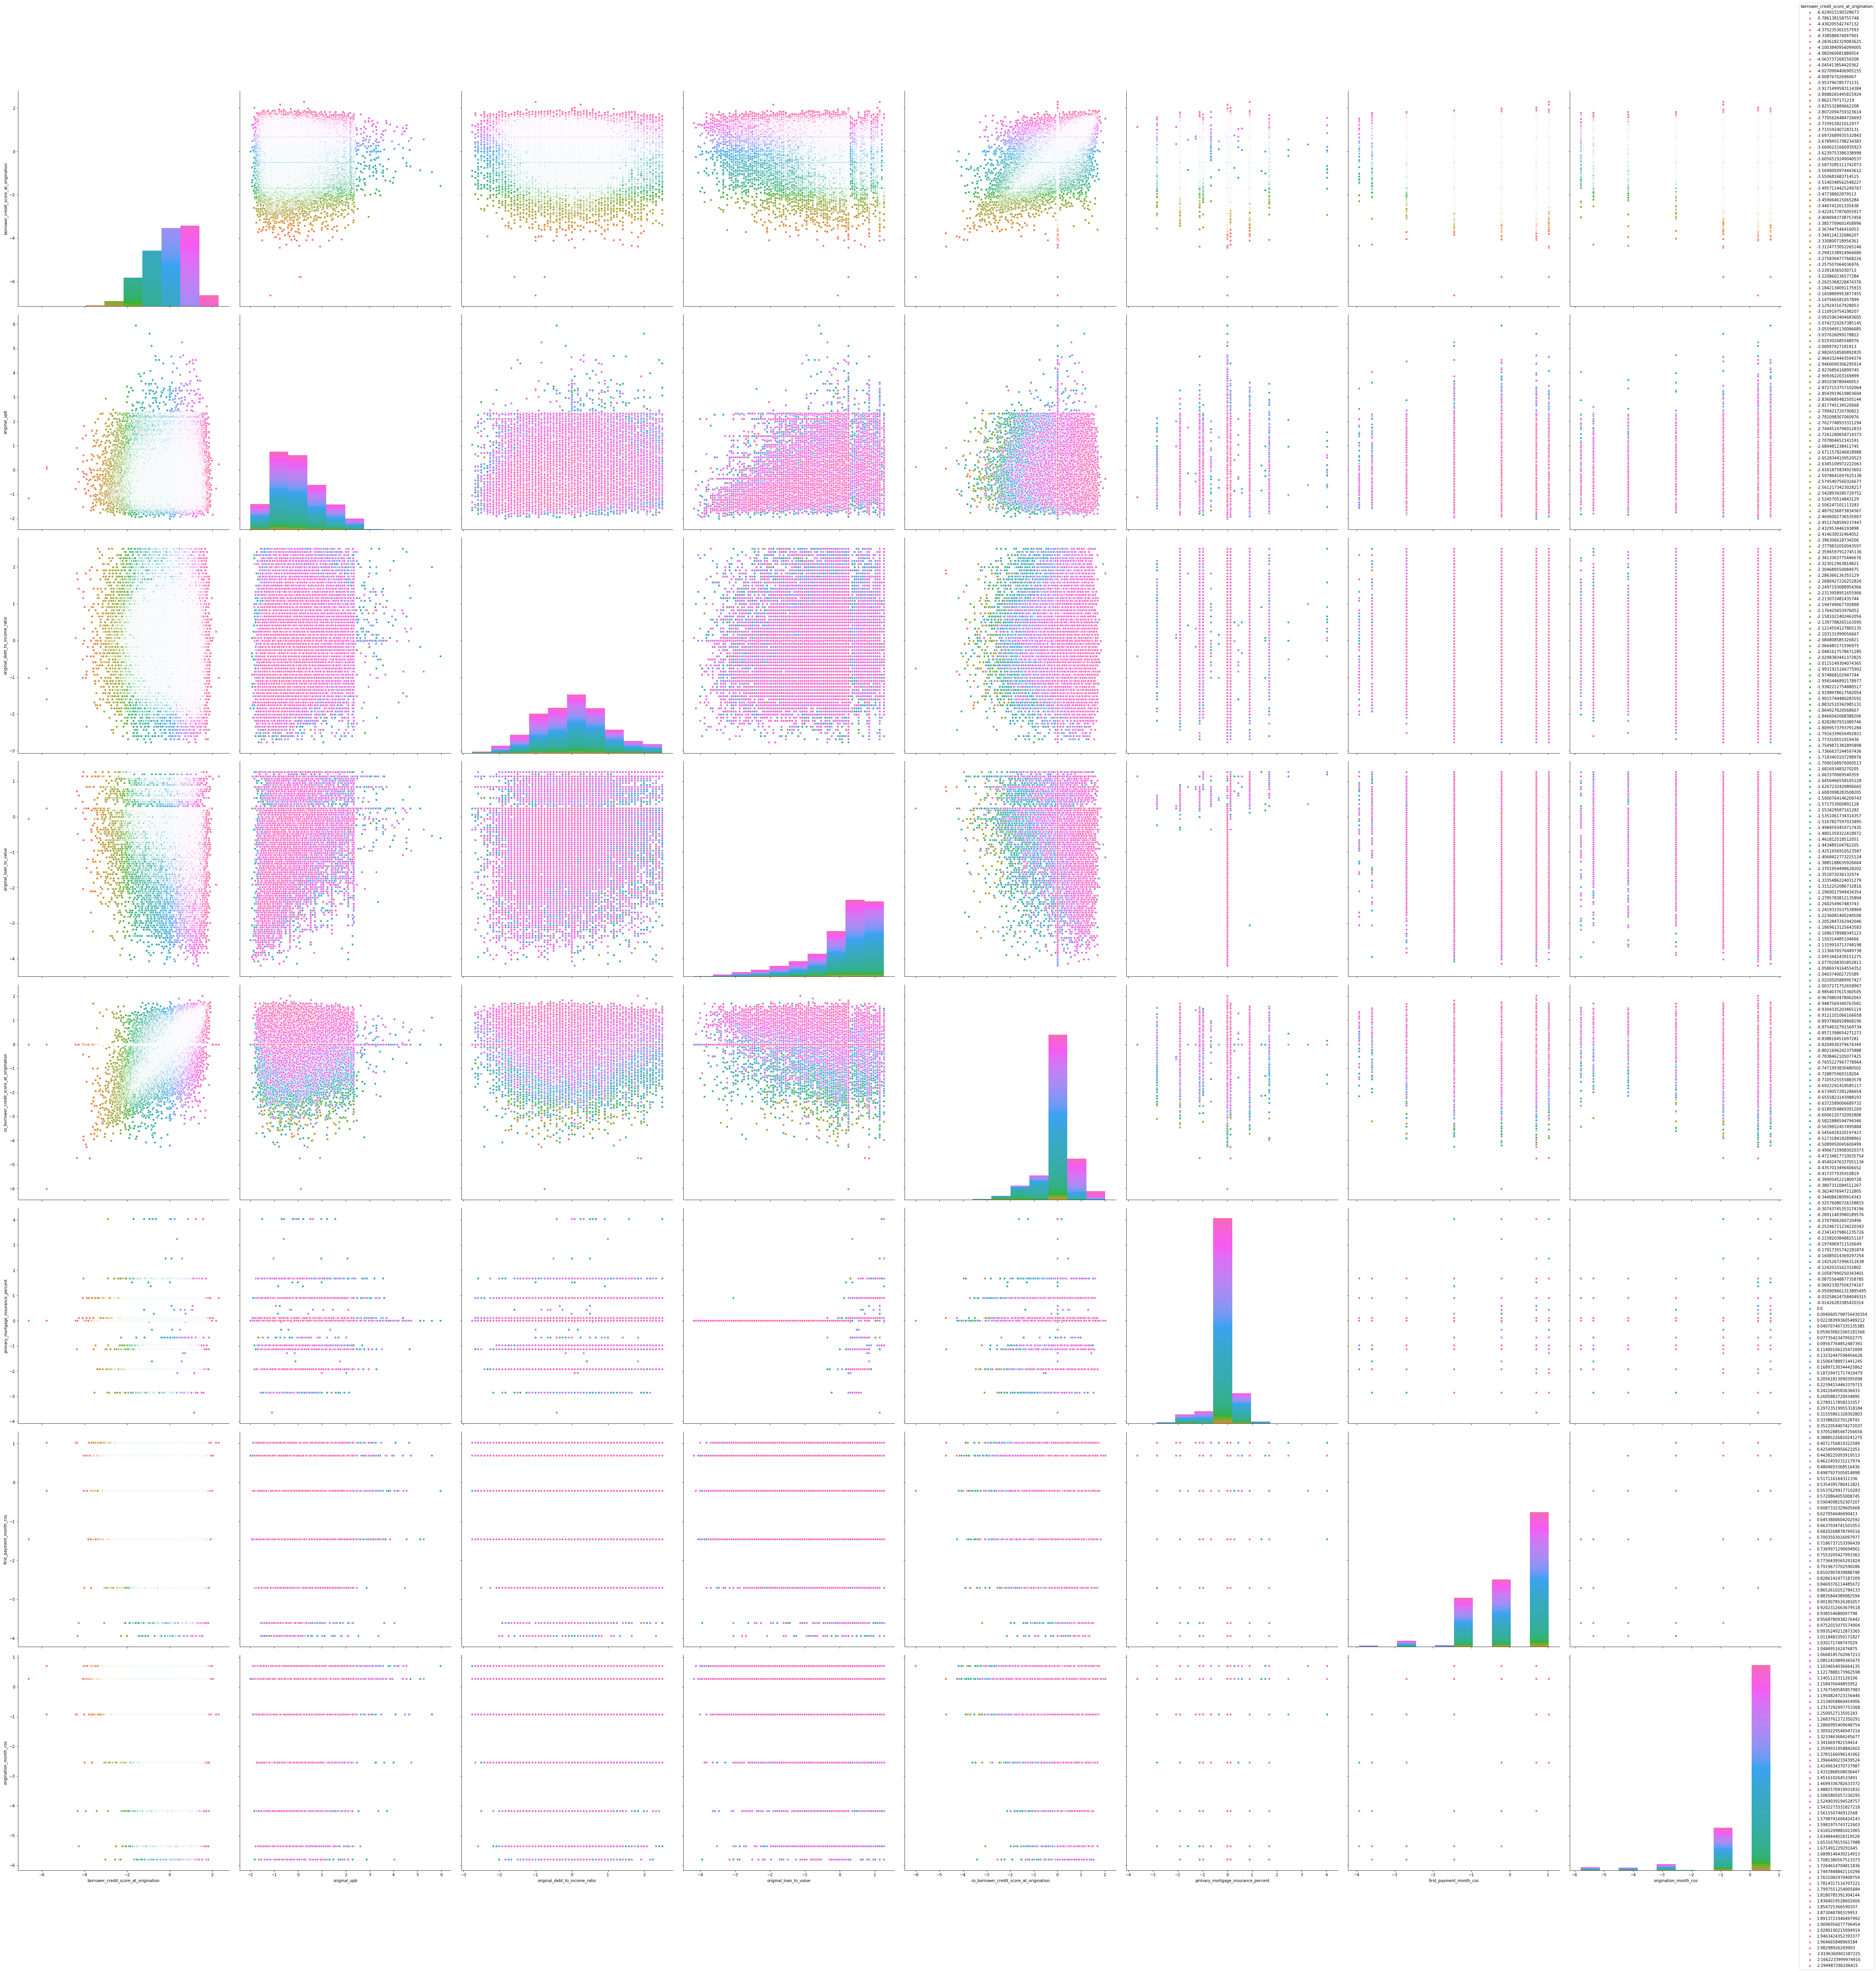

In [12]:
sns.pairplot(
    top_features, 
    size=top_features.shape[1], 
    hue="borrower_credit_score_at_origination",
)
plt.show()


In [ ]:
sns.pairplot(
    top_features, 
    size=top_features.shape[1], 
    vars=["borrower_credit_score_at_origination","original_debt_to_income_ratio"],
    hue="borrower_credit_score_at_origination",
)
plt.show()


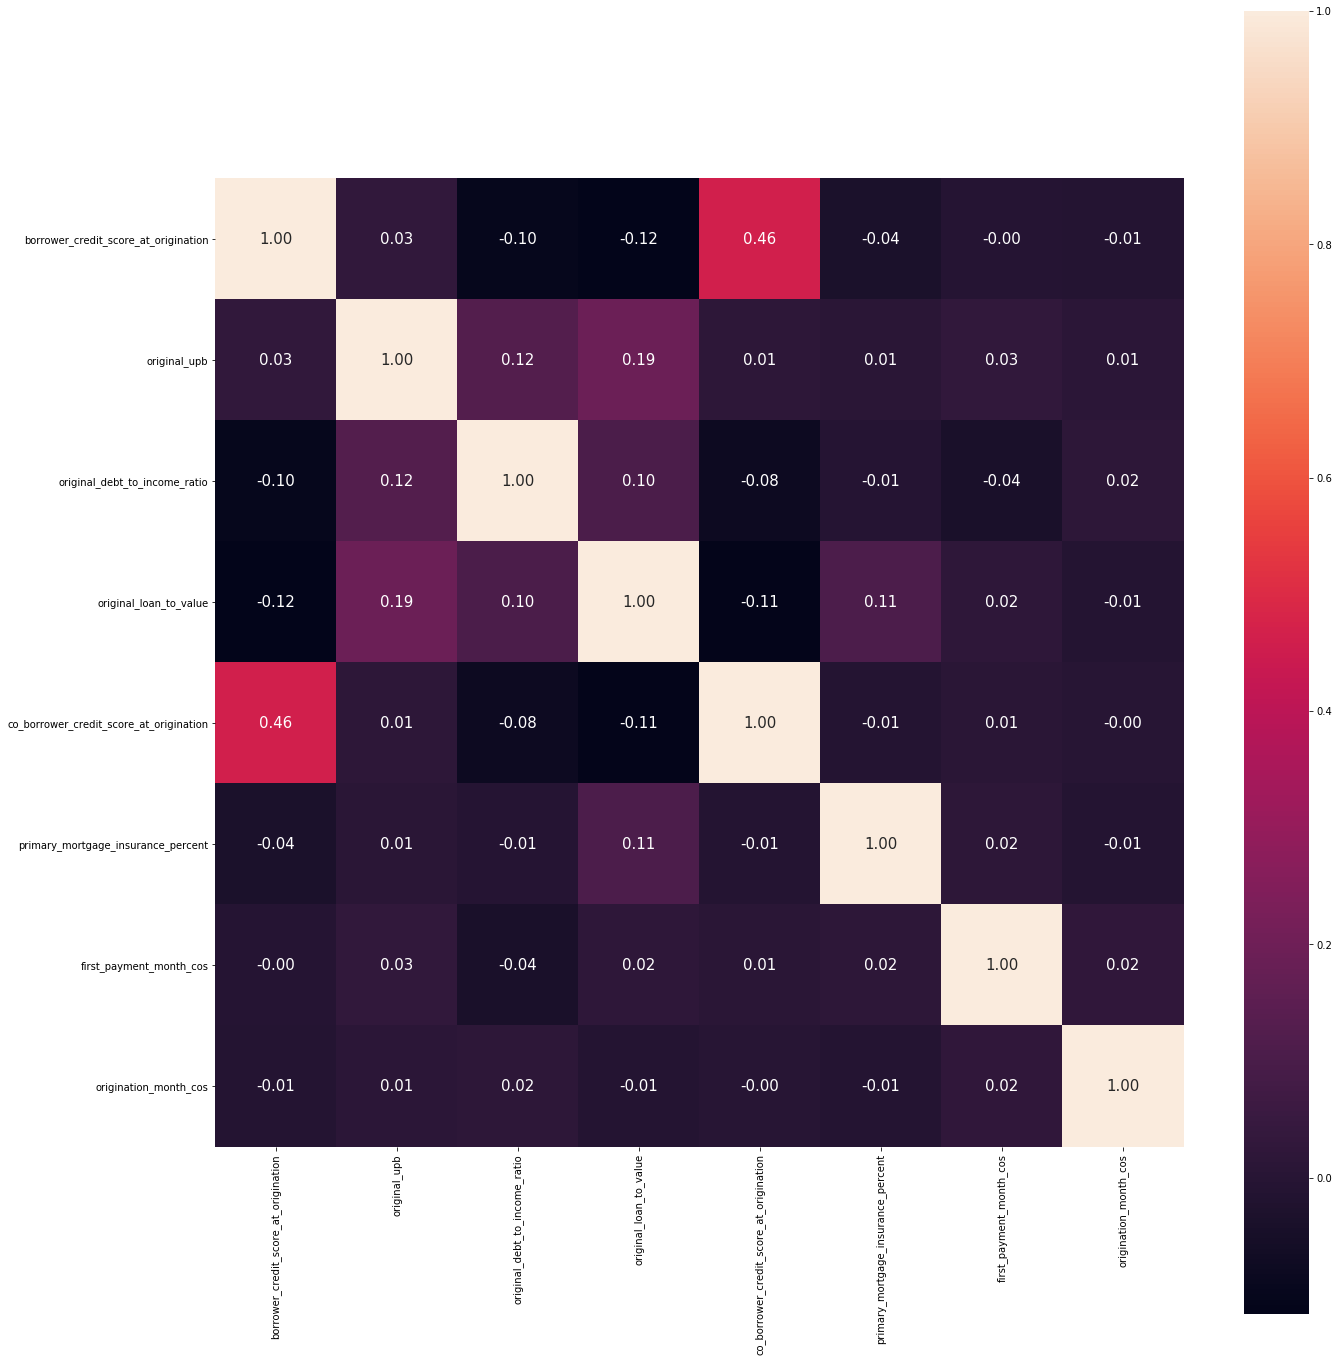

In [15]:
create_heatmap(top_features)
